# Libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.datasets as datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [2]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('default')
sns.set_palette("husl")

# Model

In [31]:
# Rede Neural
class model:
  """
  Modelo de Rede Neural Artificial para Regressão Logística
  """

  # Construtor
  def __init__(self, x: np.ndarray, y: np.ndarray, hidden_neurons: int = 10, output_neurons: int = 2):
    np.random.seed(8)

    # arquitetura da rede
    self.x = x
    self.y = y
    self.input_neurons = self.x.shape[1]
    self.hidden_neurons = hidden_neurons
    self.output_neurons = output_neurons

    # pesos e bias da primeira parte (entrada -> camada escondida)
    self.w1 = np.random.randn(self.input_neurons, self.hidden_neurons) / np.sqrt(self.input_neurons)
    self.b1 = np.zeros((1, self.hidden_neurons))

    # pesos e bias da segunda parte (camada escondida -> saída)
    self.w2 = np.random.randn(self.hidden_neurons, self.output_neurons) / np.sqrt(self.hidden_neurons)
    self.b2 = np.zeros((1, self.output_neurons))

    # dicionário do modelo
    self.model_dict = {'w1': self.w1, 'b1': self.b1, 'w2': self.w2, 'b2': self.b2}

    # equação da reta e função de ativação
    self.z1 = 0
    self.f1 = 0

  # Sinapse
  def feedforward(self, x: np.ndarray) -> np.ndarray:

    # vetor pela equação da reta (1)
    self.z1 = x.dot(self.w1) + self.b1

    # tangente hiperbólica: função de ativação (1) aplicada à camada oculta
    self.f1 = np.tanh(self.z1)

    # vetor pela equação da reta (2)
    z2 = self.f1.dot(self.w2) + self.b2

    # softmax: função de ativação (2) aplicada à camada de saída
    exp_values = np.exp(z2)
    softmax = exp_values / np.sum(exp_values, axis = 1, keepdims = True)

    return softmax

  # Perda (CCE)
  def loss(self, softmax):
    
    # predições
    predictions = np.zeros(self.y.shape[0])

    for i, correct_index in enumerate(self.y):
      predicted = softmax[i][correct_index]
      predictions[i] = predicted

    # função de erro: Categorical Cross-Entropy
    log_prob = -np.log(predicted)

    return log_prob / self.y.shape[0]

  # Otimização do aprendizado
  def backpropagation(self, softmax: np.ndarray, learning_rate: float) -> None:

    delta2 = np.copy(softmax) # predição

    # derivadas do erro (regra da cadeia): saída -> camada escondida
    delta2[range(self.x.shape[0]), self.y] -= 1                            # em relação à predição * em relação ao segundo z
    dw2 = (self.f1.T).dot(delta2)                                          # em relação ao segundo peso
    db2 = np.sum(delta2, axis = 0, keepdims = True)                        # em relação ao segundo bias
  
    # derivadas do erro (regra da cadeia): camada escondida -> entrada  
    delta1 = delta2.dot(self.w2.T) * (1 - np.power(np.tanh(self.z1), 2))   # em relação à predição * em relação ao primeiro z
    dw1 = (self.x.T).dot(delta1)                                           # em relação ao primeiro peso
    db1 = np.sum(delta1, axis = 0, keepdims = True)                        # em relação ao primeiro bias

    # atualizações dos pesos e bias
    self.w1 += - learning_rate * dw1
    self.w2 += - learning_rate * dw2
    self.b1 += - learning_rate * db1
    self.b2 += - learning_rate * db2

  # Ajuste do modelo
  def fit(self, epochs: int, lr: float, return_prediction: bool = False, show_plot: bool = False):

    # configurações prévias das grids
    num_plots = 10
    plot_idx = 0

    if show_plot:

      # eixos em 2d
      if self.x.shape[1] == 2:
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        axes = axes.flatten()

      # eixos em 3d
      elif self.x.shape[1] == 3:
        fig = plt.figure(figsize=(20, 8))
        axes = [fig.add_subplot(2, 5, i + 1, projection='3d') for i in range(num_plots)]


    #treinamento do modelo
    for epoch in range(epochs):
      outputs = self.feedforward(self.x)
      loss = self.loss(outputs)
      self.backpropagation(outputs, lr)

      # acurácia
      prediction = np.argmax(outputs, axis=1)
      correct = (prediction == self.y).sum()
      accuracy = correct / self.y.shape[0]

      # resultados
      if int(((epoch + 1) % (epochs / 10))) == 0:
        print(f'Epoch: [{epoch + 1} / {epochs}] Accuracy: {accuracy:.3f} Loss: {loss.item():.80f}')


        # gráficos por intervalo de época
        if show_plot and plot_idx < num_plots:
          ax = axes[plot_idx]

          # dados em2d
          if self.x.shape[1] == 2:
            ax.scatter(self.x[:, 0], self.x[:, 1], s=50, c=prediction, alpha=0.7, cmap='cool')

          # dados em 3d
          elif self.x.shape[1] == 3:
            ax.scatter3D(self.x[:, 0], self.x[:, 1], self.x[:, 2], s=50, c=prediction, alpha=0.7, cmap='cool')

          # títulos por época
          ax.set_title(f'Epoch {epoch + 1} - Acc: {accuracy:.2f}')
          plot_idx += 1

    # plot
    if show_plot:
        plt.tight_layout()
        plt.show()

    # retorna predição
    if return_prediction:
        return prediction

# Dataset - Banknotes

In [8]:
# Import dos dados
path = 'D:\\TERCEIRO SEMESTRE\\CÁLCULO\\ANN\\DADOS\\data_banknote_authentication.txt'
header = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
df = pd.read_csv(path, names = header)
df

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [9]:
# Separação das variáveis
x = df.drop(columns='class')
y = df['class']
labels = np.where(y == 0, 'genuine', 'forged')

print(x,
      y,
      labels)

      variance  skewness  curtosis  entropy
0      3.62160   8.66610   -2.8073 -0.44699
1      4.54590   8.16740   -2.4586 -1.46210
2      3.86600  -2.63830    1.9242  0.10645
3      3.45660   9.52280   -4.0112 -3.59440
4      0.32924  -4.45520    4.5718 -0.98880
...        ...       ...       ...      ...
1367   0.40614   1.34920   -1.4501 -0.55949
1368  -1.38870  -4.87730    6.4774  0.34179
1369  -3.75030 -13.45860   17.5932 -2.77710
1370  -3.56370  -8.38270   12.3930 -1.28230
1371  -2.54190  -0.65804    2.6842  1.19520

[1372 rows x 4 columns] 0       0
1       0
2       0
3       0
4       0
       ..
1367    1
1368    1
1369    1
1370    1
1371    1
Name: class, Length: 1372, dtype: int64 ['genuine' 'genuine' 'genuine' ... 'forged' 'forged' 'forged']


# PCA

In [12]:
# Normalização

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled

array([[ 1.12180565,  1.14945512, -0.97597007,  0.35456135],
       [ 1.44706568,  1.06445293, -0.89503626, -0.12876744],
       [ 1.20780971, -0.77735215,  0.12221838,  0.61807317],
       ...,
       [-1.47235682, -2.62164576,  3.75901744, -0.75488418],
       [-1.40669251, -1.75647104,  2.552043  , -0.04315848],
       [-1.04712236, -0.43982168,  0.29861555,  1.1364645 ]],
      shape=(1372, 4))

In [13]:
# PCA

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)
print("Variância explicada pelos 2 primeiros componentes:",
      f"{sum(pca.explained_variance_ratio_):.2%}")

Variância explicada pelos 2 primeiros componentes: 86.83%


In [14]:
# Visualização dos dados pós PCA

def plot_pca(x_pca, labels=None, title="PCA - Projeção 2D"):
    """
    Visualiza os dados após PCA em 2D
    """
    plt.figure(figsize=(10, 8))

    # com labels
    if labels is not None:

      unique_labels = np.unique(labels)
      colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

      # retorna labels
      for i, label in enumerate(unique_labels):
        mask = labels == label
        plt.scatter(x_pca[mask, 0], x_pca[mask, 1],
                       c=[colors[i]], label=f'{label}',
                       alpha=0.7, s=50)
        plt.legend()

    # sem labels
    else:
      plt.scatter(x_pca[:, 0], x_pca[:, 1],
                   alpha=0.7, s=50, color='steelblue')

    plt.xlabel('Primeira Componente (PC1)')
    plt.ylabel('Segunda Componente (PC2)')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

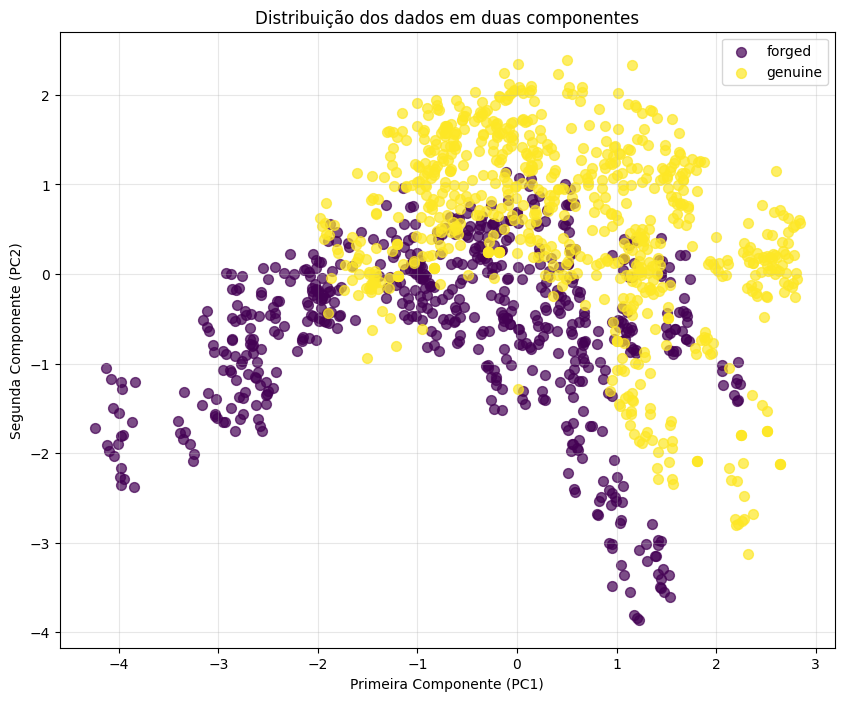

In [15]:
# PCA classificado
plot_pca(x_pca, labels=labels, title="Distribuição dos dados em duas componentes")

# Resultados (Com PCA x Sem PCA)

In [32]:
hidden_neurons = 10
output_neurons = 4
epochs = 20
learning_rate = 0.001

In [33]:
# Sem PCA
modelo = model(x.to_numpy(), y, hidden_neurons = hidden_neurons, output_neurons = output_neurons)
modelo.fit(epochs = epochs, lr = learning_rate)

Epoch: [2 / 20] Accuracy: 0.882 Loss: 0.00013241049784455853426633209490859144352725706994533538818359375000000000000000
Epoch: [4 / 20] Accuracy: 0.819 Loss: 0.00012550450552512869869907496944705371788586489856243133544921875000000000000000
Epoch: [6 / 20] Accuracy: 0.954 Loss: 0.00012756107828103242047765308875284517853287979960441589355468750000000000000000
Epoch: [8 / 20] Accuracy: 0.981 Loss: 0.00005599730669125075715715847413100902940641390159726142883300781250000000000000
Epoch: [10 / 20] Accuracy: 0.988 Loss: 0.00003459953741130095160923735297942016586603131145238876342773437500000000000000
Epoch: [12 / 20] Accuracy: 0.988 Loss: 0.00002365048977119774855477039865458976919398992322385311126708984375000000000000
Epoch: [14 / 20] Accuracy: 0.992 Loss: 0.00001819405067075731605966311399402712822848116047680377960205078125000000000000
Epoch: [16 / 20] Accuracy: 0.994 Loss: 0.00001493088963775627596246818595826511000268510542809963226318359375000000000000
Epoch: [18 / 20] Accuracy: 0

In [34]:
hidden_neurons = 200
output_neurons = 2
epochs = 300
learning_rate = 0.001

Epoch: [30 / 300] Accuracy: 0.771 Loss: 0.00000000000001297342537912446922705695284911188205709687681216335519707172352355
Epoch: [60 / 300] Accuracy: 0.789 Loss: 0.00000484357864582040141066335281472277074499288573861122131347656250000000000000
Epoch: [90 / 300] Accuracy: 0.759 Loss: 0.00085022355331648116934240011488554955576546490192413330078125000000000000000000
Epoch: [120 / 300] Accuracy: 0.811 Loss: 0.00012612086573237250093811046003366982404259033501148223876953125000000000000000
Epoch: [150 / 300] Accuracy: 0.772 Loss: 0.00011251677084578846389784079207174727343954145908355712890625000000000000000000
Epoch: [180 / 300] Accuracy: 0.802 Loss: 0.00048749042509902719682440830339942294813226908445358276367187500000000000000000
Epoch: [210 / 300] Accuracy: 0.769 Loss: 0.00002200591606686223901151629178674085096645285375416278839111328125000000000000
Epoch: [240 / 300] Accuracy: 0.816 Loss: 0.00010475709799469555593212644062361960095586255192756652832031250000000000000000
Epoch: [270

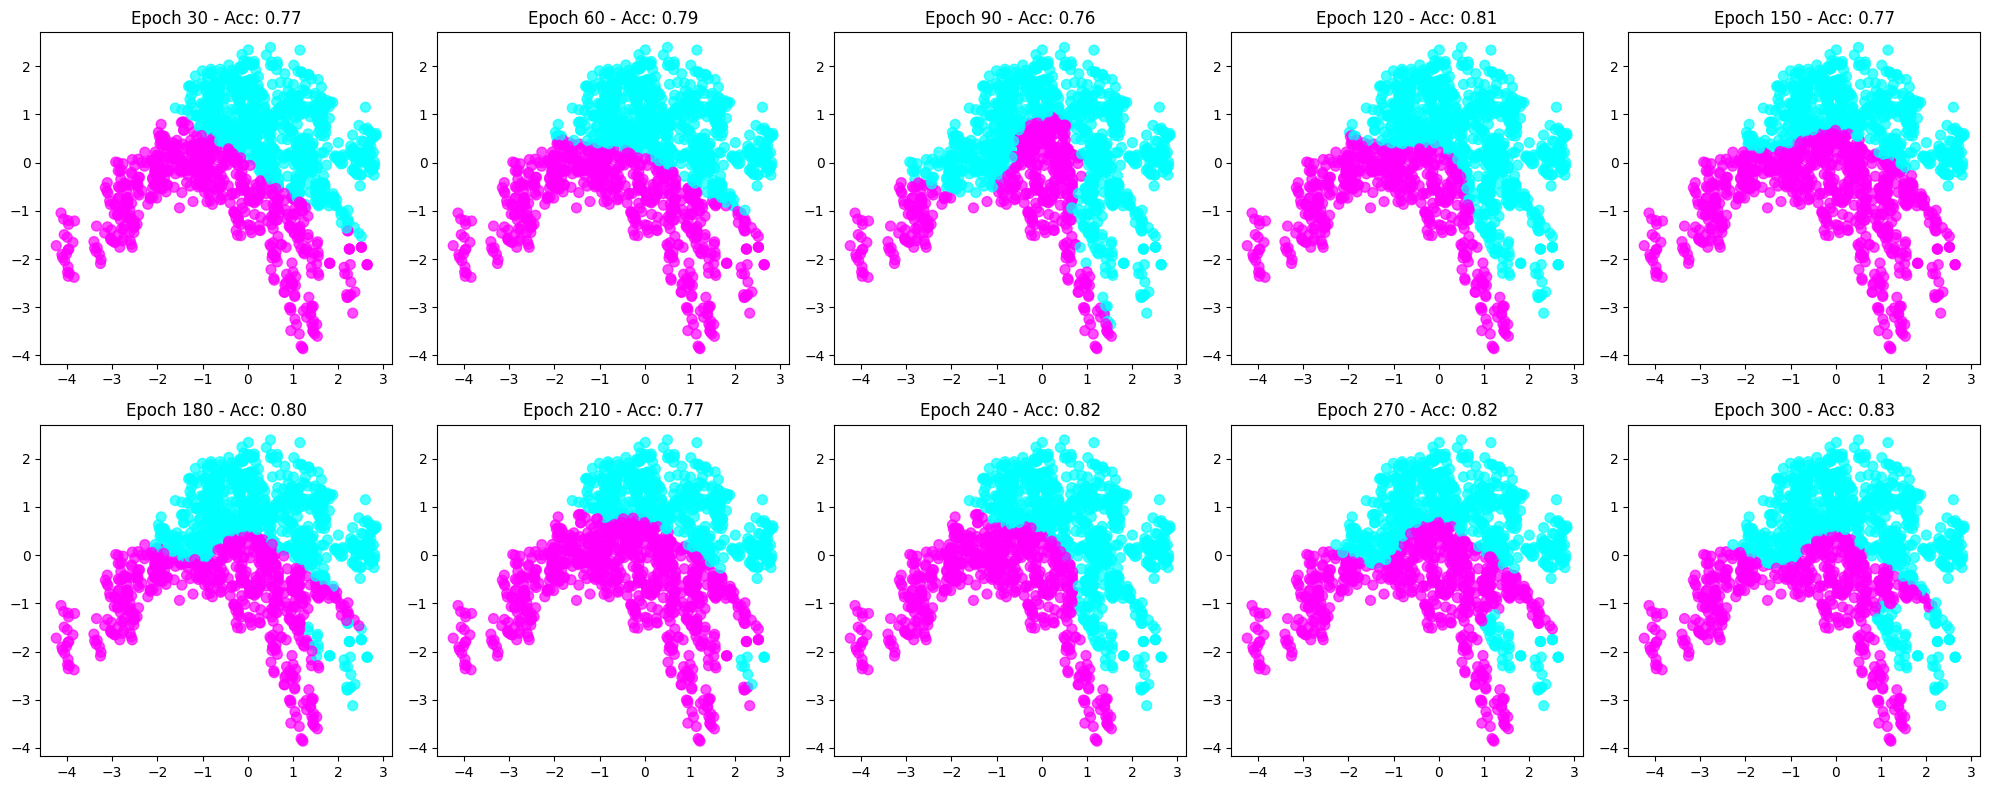

In [35]:
# Com PCA
modelo_pca = model(x_pca, y, hidden_neurons = hidden_neurons, output_neurons = output_neurons)
modelo_pca.fit(epochs = epochs, lr = learning_rate, show_plot=True)